<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%206%20/%20Tugas%20/%20Pytorch_DeteksiSarkasme_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library and Dataset

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Model hyperparameters
num_words = 10000
maxlen = 100
epochs = 10
batch_size = 64
embedding_dim = 256
hidden_dim = 1024
output_dim = 1
n_layers = 2
dropout = 0.2

# Load data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

file_path = "DeteksiSarkasme.json"

data = load_data(file_path)

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['processed_headline'] = data['headline'].apply(preprocess_text)

In [ ]:
# Tokenization
def build_vocabulary(texts, max_words=num_words):
    word_counts = {}
    for text in texts:
        for word in text.split():
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    vocabulary = {'<PAD>': 0, '<UNK>': 1}
    for i, (word, _) in enumerate(sorted_words[:max_words-2]):
        vocabulary[word] = i + 2

    return vocabulary

def text_to_sequence(text, vocabulary, maxlen):
    sequence = []
    for word in text.split():
        if word in vocabulary:
            sequence.append(vocabulary[word])
        else:
            sequence.append(vocabulary['<UNK>'])

    if len(sequence) < maxlen:
        sequence = sequence + [vocabulary['<PAD>']] * (maxlen - len(sequence))
    else:
        sequence = sequence[:maxlen]

    return sequence

vocabulary = build_vocabulary(data['processed_headline'])

data['sequence'] = data['processed_headline'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# Train-test split
x = np.array(data['sequence'].tolist())
y = np.array(data['is_sarcastic'].tolist())
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Dataset
class SarcasmDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Datasets and dataloaders
train_dataset = SarcasmDataset(x_train, y_train)
test_dataset = SarcasmDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#RNN

In [ ]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.RNN = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.RNN(embedded)
        attn_weights = torch.softmax(self.attention(output), dim=1)
        context_vector = torch.sum(attn_weights * output, dim=1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out.squeeze(-1)

In [ ]:
# Model training setup
vocab_size = len(vocabulary)
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
train_loss_list, test_loss_list, train_acc_list, test_acc_list = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / train_total

    # Testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_loss = test_loss / len(test_dataset)
    test_acc = test_correct / test_total

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/10] Train Acc: 0.6869, Train Loss: 0.5483 | Test Acc: 0.7048, Test Loss: 0.5123
Epoch [2/10] Train Acc: 0.7484, Train Loss: 0.4745 | Test Acc: 0.7409, Test Loss: 0.4841
Epoch [3/10] Train Acc: 0.7735, Train Loss: 0.4375 | Test Acc: 0.7362, Test Loss: 0.4942
Epoch [4/10] Train Acc: 0.7998, Train Loss: 0.4037 | Test Acc: 0.7595, Test Loss: 0.4811
Epoch [5/10] Train Acc: 0.8192, Train Loss: 0.3731 | Test Acc: 0.7602, Test Loss: 0.4821
Epoch [6/10] Train Acc: 0.8383, Train Loss: 0.3445 | Test Acc: 0.7596, Test Loss: 0.4786
Epoch [7/10] Train Acc: 0.8553, Train Loss: 0.3176 | Test Acc: 0.7645, Test Loss: 0.4926
Epoch [8/10] Train Acc: 0.8716, Train Loss: 0.2862 | Test Acc: 0.7643, Test Loss: 0.5440
Epoch [9/10] Train Acc: 0.8859, Train Loss: 0.2628 | Test Acc: 0.7649, Test Loss: 0.5294
Epoch [10/10] Train Acc: 0.8983, Train Loss: 0.2379 | Test Acc: 0.7624, Test Loss: 0.5951


Accuracy : 0.7624
Precision: 0.7707
Recall: 0.6535
F1 Score: 0.7073
F1 Squared: 0.5002
AUC: 0.8446


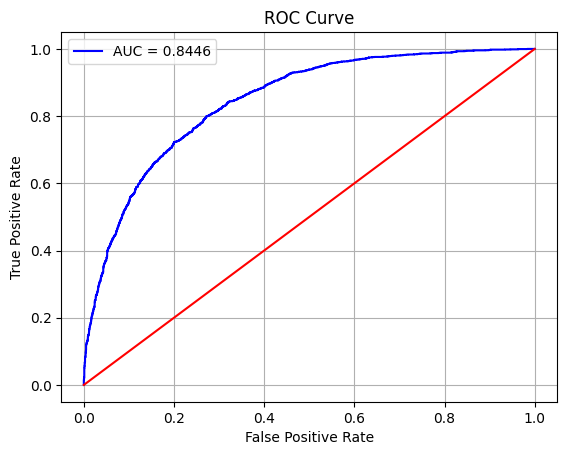

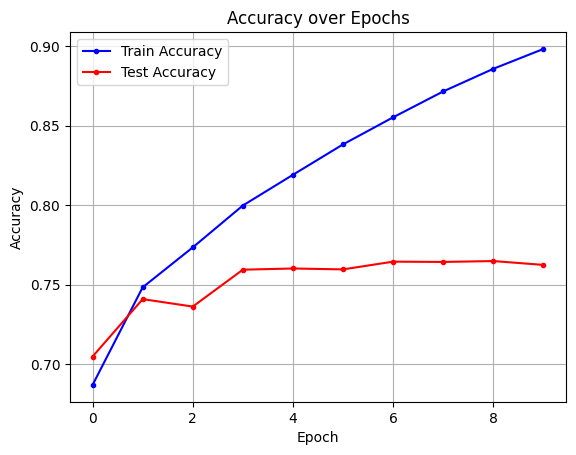

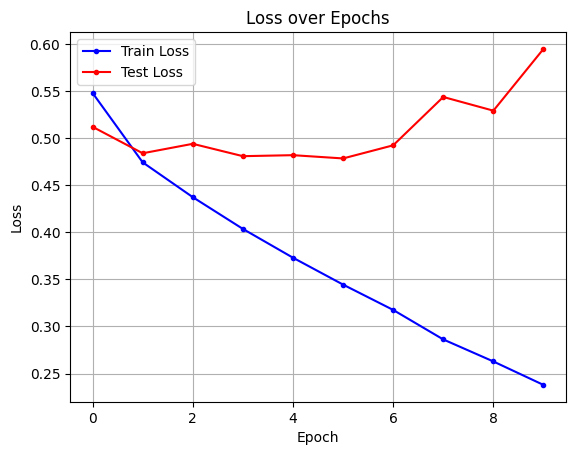

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
binary_preds = (all_preds >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
f1_sq = f1_score(all_labels, binary_preds)**2
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#LSTM

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(output), dim=1)
        context_vector = torch.sum(attn_weights * output, dim=1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out.squeeze(-1)

In [ ]:
# Model training setup
vocab_size = len(vocabulary)
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
train_loss_list, test_loss_list, train_acc_list, test_acc_list = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / train_total

    # Testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_loss = test_loss / len(test_dataset)
    test_acc = test_correct / test_total

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/10] Train Acc: 0.6819, Train Loss: 0.5535 | Test Acc: 0.7173, Test Loss: 0.5204
Epoch [2/10] Train Acc: 0.7484, Train Loss: 0.4790 | Test Acc: 0.7379, Test Loss: 0.4868
Epoch [3/10] Train Acc: 0.7754, Train Loss: 0.4394 | Test Acc: 0.7458, Test Loss: 0.4948
Epoch [4/10] Train Acc: 0.8018, Train Loss: 0.4018 | Test Acc: 0.7572, Test Loss: 0.4651
Epoch [5/10] Train Acc: 0.8224, Train Loss: 0.3709 | Test Acc: 0.7686, Test Loss: 0.4775
Epoch [6/10] Train Acc: 0.8080, Train Loss: 0.3847 | Test Acc: 0.7155, Test Loss: 0.5350
Epoch [7/10] Train Acc: 0.8319, Train Loss: 0.3521 | Test Acc: 0.7435, Test Loss: 0.5195
Epoch [8/10] Train Acc: 0.8663, Train Loss: 0.2979 | Test Acc: 0.7668, Test Loss: 0.5163
Epoch [9/10] Train Acc: 0.8827, Train Loss: 0.2679 | Test Acc: 0.7641, Test Loss: 0.5316
Epoch [10/10] Train Acc: 0.8934, Train Loss: 0.2462 | Test Acc: 0.7649, Test Loss: 0.5659


Accuracy : 0.7649
Precision: 0.7890
Recall: 0.6343
F1 Score: 0.7032
F1 Squared: 0.4945
AUC: 0.8553


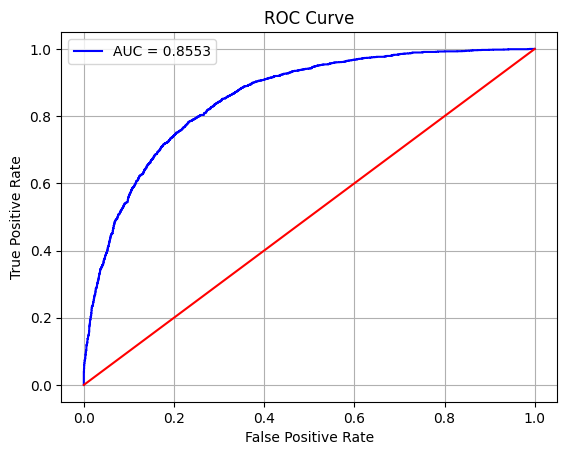

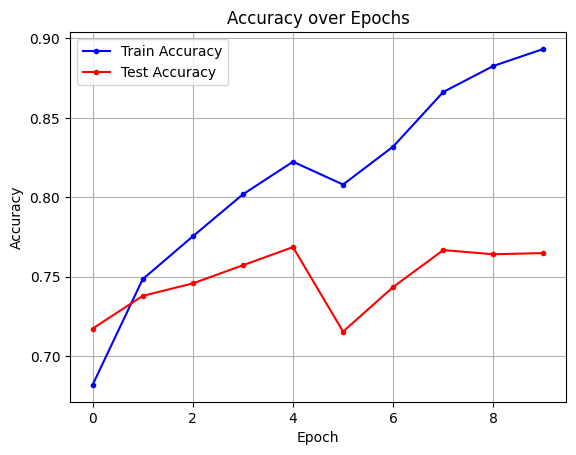

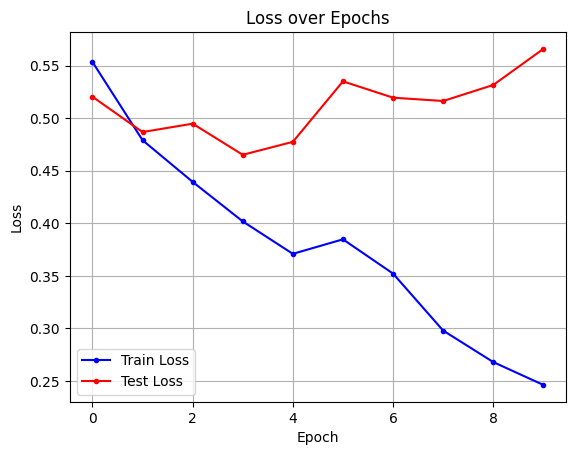

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
binary_preds = (all_preds >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
f1_sq = f1_score(all_labels, binary_preds)**2
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#GRU

In [ ]:
# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.gru(embedded)
        attn_weights = torch.softmax(self.attention(output), dim=1)
        context_vector = torch.sum(attn_weights * output, dim=1)
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)
        return out.squeeze(-1)

In [ ]:
# Model training setup
vocab_size = len(vocabulary)
model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training
train_loss_list, test_loss_list, train_acc_list, test_acc_list = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / train_total

    # Testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_loss = test_loss / len(test_dataset)
    test_acc = test_correct / test_total

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1/10] Train Acc: 0.6844, Train Loss: 0.5455 | Test Acc: 0.7216, Test Loss: 0.4937
Epoch [2/10] Train Acc: 0.7651, Train Loss: 0.4511 | Test Acc: 0.7772, Test Loss: 0.4446
Epoch [3/10] Train Acc: 0.8048, Train Loss: 0.3948 | Test Acc: 0.7971, Test Loss: 0.4145
Epoch [4/10] Train Acc: 0.8359, Train Loss: 0.3419 | Test Acc: 0.8182, Test Loss: 0.3975
Epoch [5/10] Train Acc: 0.8662, Train Loss: 0.2883 | Test Acc: 0.8295, Test Loss: 0.3927
Epoch [6/10] Train Acc: 0.8923, Train Loss: 0.2424 | Test Acc: 0.8253, Test Loss: 0.4104
Epoch [7/10] Train Acc: 0.9153, Train Loss: 0.1948 | Test Acc: 0.8244, Test Loss: 0.4389
Epoch [8/10] Train Acc: 0.9347, Train Loss: 0.1575 | Test Acc: 0.8244, Test Loss: 0.4540
Epoch [9/10] Train Acc: 0.9486, Train Loss: 0.1272 | Test Acc: 0.8261, Test Loss: 0.5635
Epoch [10/10] Train Acc: 0.9584, Train Loss: 0.1030 | Test Acc: 0.8210, Test Loss: 0.5212


Accuracy : 0.8210
Precision: 0.8380
Recall: 0.7344
F1 Score: 0.7828
F1 Squared: 0.6128
AUC: 0.9047


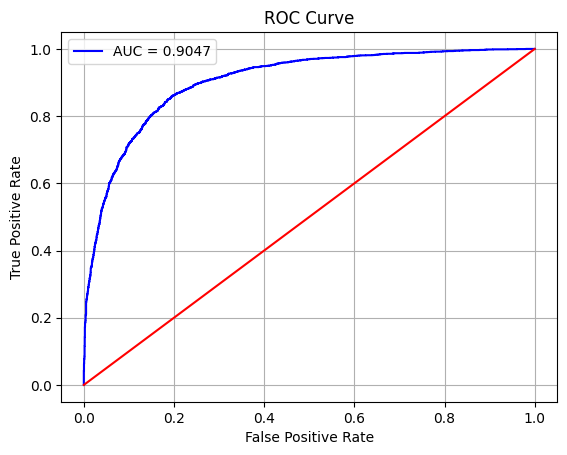

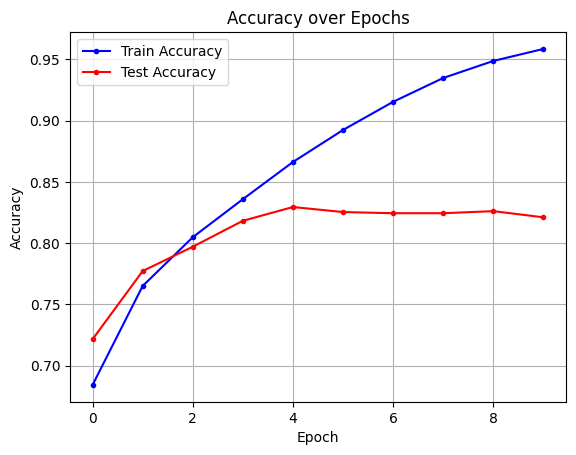

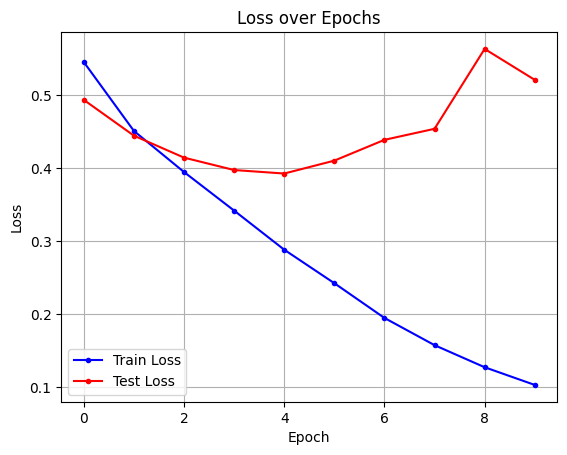

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
binary_preds = (all_preds >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
f1_sq = f1_score(all_labels, binary_preds)**2
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#Persamaan Matematika pada DL

---

##1. RNN
RNN memproses urutan data dengan mempertahankan hidden state dari langkah sebelumnya. Persamaan matematikanya:

$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$

---

##2. LSTM
LSTM menggunakan tiga gate utama: forget gate, input gate, dan output gate, serta sebuah cell state yang menyimpan memori jangka panjang.

$f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)$ (forget gate)

$i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)$ ,
$\tilde{C}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c)$ (input gate)

$C_t = f_t . C_{t-1} + i_t . \tilde{C}_t$ (update cell state)

$o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$ (output gate)

$h_t = o_t . \tanh(C_t)$ (hidden state)

---

##3. GRU
GRU menyederhanakan LSTM dengan dua gate.

$z_t = \sigma(W_z x_t + U_z h_{t-1})$ (update gate)

$r_t = σ(W_r x_t + U_r h_{t-1})$ (reset gate)

$\tilde{h_t} = tanh(W_h x_t + U_h (r_t . h_{t-1}))$ (kandidat hidden state)

$h_t = (1 - z_t) . h_{t-1} + z_t . \tilde{h_t}$ (final hidden state)

---

##4. Binary Cross-Entropy Loss
Untuk klasifikasi biner, fungsi loss adalah:

\[
\$mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$\]

($ y_i $): Label sebenarnya (0 atau 1)

($ \hat{y}_i $): Prediksi model

---

#Persamaan Matematika Evaluasi Model Klasifikasi
TP = True Positive

TN = True Negative

FP = False Positive

FN = False Negative

---

##1. Akurasi (Accuracy)
Akurasi mengukur seberapa sering model membuat prediksi yang benar dari keseluruhan data.

Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

---

##2. Presisi (Precision)
Presisi mengukur seberapa akurat prediksi positif yang dibuat oleh model.

$Accuracy = \frac{TP}{TP + FP}$

---

##3. Recall (Sensitivity / True Positive Rate)
Recall mengukur seberapa banyak dari data positif yang berhasil ditangkap oleh model.

$Recall = \frac{TP}{TP + FN}$

---

##4. F1 Score
F1 Score adalah rata-rata harmonik dari precision dan recall.

$F1 = 2 \times \frac{(Precision \times Recall)}{(Precision + Recall)}$

F1 Squared adalah nilai F1 Score dipangkatkan 2.

$F1_{sq} = F1^2$

---

##5. ROC (Receiver Operating Characteristic) Curve
ROC adalah kurva yang menampilkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

$TPR = \frac{TP}{TP + FN}$

$FPR = \frac{TP}{FP + TN}$

Kurva ini dibentuk dengan memplot TPR vs FPR pada berbagai threshold klasifikasi.

---

##6. AUC (Area Under Curve):
AUC mengukur luas di bawah kurva ROC. Nilai berkisar antara 0-1. Semakin mendekati 1, semakin baik kemampuan model membedakan kelas positif dan negatif.

---